In [1]:
import os
import re
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import plotly as px
import plotly.graph_objects as go
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

In [2]:
direccion='../limpiezacolumnas/salida/'

In [3]:
dd=pd.DataFrame()
for path, subdirs, files in os.walk(direccion):
        for name in tqdm(files):
            if(len(name)<8):
                print(name)
            
                df=pd.read_csv(os.path.join(path, name))
                df["Hora"]=pd.to_datetime(df["Hora"],dayfirst=True)
                df = df.set_index('Hora')
                ix=df.index.values-3
                imputer = KNNImputer(n_neighbors=6)
                df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
                df['index']=ix
                dff = df.set_index('index')
                df=pd.melt(df, id_vars=['index'], var_name='NIS', value_name='KWh')
                df["cat"]=name[:3]
                
                dd = pd.concat([dd, df],axis=0)
                  #df["Hora"] 

 33%|███▎      | 2/6 [00:00<00:00, 11.43it/s]

141.csv
142.csv
245.csv
343.csv


100%|██████████| 1/1 [00:00<?, ?it/s]

546.csv
846.csv


In [4]:

dd['hour'] = dd['index'].apply(lambda x: x.hour)

In [5]:
dd['day'] = dd['index'].apply(lambda x: x.dayofweek)

In [6]:
dd.head()

,index,NIS,KWh,cat,hour,day
0,2021-12-01 00:59:59.999999997,1572256,0.052,141,0,2
1,2021-12-01 01:59:59.999999997,1572256,0.046,141,1,2
2,2021-12-01 02:59:59.999999997,1572256,0.042,141,2,2
3,2021-12-01 03:59:59.999999997,1572256,0.044,141,3,2
4,2021-12-01 04:59:59.999999997,1572256,0.052,141,4,2


In [7]:
dd['max_KWh'] = dd.groupby(['cat','day'])['KWh'].transform(max)

In [8]:
dd['norm_KWh'] = dd['KWh'] / dd['max_KWh']

In [12]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn import cluster 

In [13]:
red_df = dd[['cat','NIS',  'day', 'hour', 'norm_KWh']]
piv_df = pd.pivot_table(red_df, index = ['cat','NIS',  'day'], columns = 'hour', values = 'norm_KWh')
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby(['cat', 'day']).mean()
grp_df.reset_index(inplace = True)
#del grp_df['day'] # This feature is not relevant any more

In [14]:
grp_df.head()

hour,cat,day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,141,0,0.120709,0.108471,0.106166,0.101640,0.100905,0.108447,0.097690,0.083008,0.077209,0.080598,0.087385,0.096476,0.093745,0.086294,0.081246,0.076207,0.073265,0.078237,0.088998,0.109444,0.148510,0.141461,0.112993,0.109210
1,141,1,0.077231,0.072824,0.074336,0.070273,0.070445,0.078472,0.070891,0.057872,0.054382,0.057649,0.058600,0.067942,0.070686,0.071151,0.065785,0.059240,0.055440,0.064938,0.067746,0.083092,0.118475,0.119271,0.103942,0.093566
2,141,2,0.104551,0.102359,0.095183,0.095930,0.094777,0.100777,0.091306,0.075726,0.074416,0.075721,0.080623,0.085637,0.091566,0.087399,0.085481,0.088158,0.075857,0.074311,0.075784,0.098128,0.139496,0.132340,0.124109,0.115830
3,141,3,0.123230,0.118631,0.111138,0.107426,0.108523,0.113160,0.106330,0.083156,0.079909,0.079904,0.091286,0.102682,0.094291,0.093611,0.090697,0.084477,0.083428,0.082054,0.091002,0.110681,0.157747,0.145581,0.140227,0.131087
4,141,4,0.106599,0.099854,0.097268,0.093891,0.094634,0.098428,0.092130,0.084333,0.071863,0.063236,0.074731,0.092504,0.098588,0.095798,0.086220,0.085895,0.088719,0.091126,0.098010,0.113416,0.153865,0.146340,0.127394,0.115672


In [15]:
kmeans_df = grp_df#pd.get_dummies(grp_df, columns =['cat','NIS'])

In [17]:
def elbow_method(dataframe, min_k, max_k):
    # Try all k's between min_k and max_k
    cluster_nums = range(min_k, max_k + 1)
    
    # Array of K-means algorithm objects
    k_mean_algs = [cluster.KMeans(n_clusters = k) for k in cluster_nums]
    
    # Array with the results of the K-mean algorithms
    k_mean_res = [alg.fit(dataframe) for alg in k_mean_algs]
    
    # Array with the centroids for each value of k
    centroids = [res.cluster_centers_ for res in k_mean_res]
    
    # Euclidean distance between the points of the cluster and the centroids
    distances = [cdist(dataframe, centroid, 'euclidean') for centroid in centroids]
    
    # Get the closest centroid (and the corresponding distance)
    min_indices = [np.argmin(distance, axis = 1) for distance in distances]
    min_distances = [np.min(distance, axis = 1) for distance in distances]
    
    # Calculate the average squared distance
    avg_sum_squares = [sum(dist ** 2) / kmeans_df.shape[0] for dist in min_distances]

    # Plot the elbow graph
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(cluster_nums, avg_sum_squares, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average sum of squares within cluster')
    plt.show()
    
    return (k_mean_algs, k_mean_res)

D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\UserFiles\anaconda\envs\ia\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by s

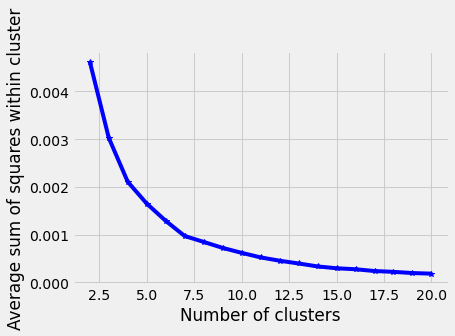

In [18]:
k_algs, k_res = elbow_method(kmeans_df.drop(['cat', 'day'], axis = 1), 2, 20)

In [19]:
algorithm = k_algs[4] # Values of k are {2, 3, 4, 5, ..., 20} so k = 6 corresponds to the element with index 4
clustering = k_res[4]

In [20]:
clustering.cluster_centers_

array([[0.10412506, 0.09688662, 0.09372563, 0.09211366, 0.09926712,
        0.10880897, 0.12349339, 0.14161175, 0.14665227, 0.14299707,
        0.14315553, 0.14215896, 0.1315453 , 0.13594259, 0.13490688,
        0.13454846, 0.13135774, 0.12416472, 0.11911124, 0.12030064,
        0.12126234, 0.1210013 , 0.11531843, 0.11357191],
       [0.08501292, 0.08428754, 0.08387373, 0.08194896, 0.08199475,
        0.08246737, 0.08173063, 0.0835662 , 0.08495342, 0.08642739,
        0.08605333, 0.08602922, 0.086454  , 0.08726355, 0.08963242,
        0.09088716, 0.09167148, 0.09303636, 0.09180367, 0.09418674,
        0.09768922, 0.09638738, 0.09266755, 0.08797632],
       [0.10820531, 0.10721174, 0.1056254 , 0.10227763, 0.10268541,
        0.10329587, 0.10246652, 0.10466424, 0.10579876, 0.10564693,
        0.1050358 , 0.10480373, 0.10682025, 0.10900851, 0.11001818,
        0.10954545, 0.10907841, 0.10874088, 0.10772063, 0.10612872,
        0.10701069, 0.10711675, 0.10647747, 0.10774684],
       [0.115

In [22]:
cls_list = algorithm.predict(kmeans_df.drop(['cat', 'day'], axis = 1))

In [23]:
kmeans_df['cluster'] = cls_list

In [24]:
def print_building_types_in_clusters(data):
    for tp in data['cat'].unique():
        print('How many cat of type', tp, 'are in each cluster?')
        print(data[data.cat == tp]['cluster'].value_counts())

In [25]:
print_building_types_in_clusters(kmeans_df)

How many cat of type 141 are in each cluster?
3    6
1    1
Name: cluster, dtype: int64
How many cat of type 142 are in each cluster?
5    4
2    3
Name: cluster, dtype: int64
How many cat of type 245 are in each cluster?
2    7
Name: cluster, dtype: int64
How many cat of type 343 are in each cluster?
0    4
4    3
Name: cluster, dtype: int64
How many cat of type 546 are in each cluster?
1    5
2    2
Name: cluster, dtype: int64
How many cat of type 846 are in each cluster?
1    6
5    1
Name: cluster, dtype: int64


In [26]:
def make_cluster_table(data):
    tbl = data[['cat', 'cluster']]
    tbl_grp = tbl.groupby(tbl.columns.tolist(), as_index = False).size()
    tbl_frm = tbl_grp#.reset_index().drop('index')
    
    tbl_frm.columns = ['cat', 'cluster','count']
    tbl_pvt = pd.pivot_table(tbl_frm, index = 'cat', columns = 'cluster', values = 'count').fillna(0).astype(int)
    return (tbl_frm, tbl_pvt)

In [27]:
tbl_frm, tbl_pvt = make_cluster_table(kmeans_df)
tbl_pvt

cluster,0,1,2,3,4,5
cat,,,,,,
141,0,1,0,6,0,0
142,0,0,3,0,0,4
245,0,0,7,0,0,0
343,4,0,0,0,3,0
546,0,5,2,0,0,0
846,0,6,0,0,0,1


In [28]:


from matplotlib.ticker import MaxNLocator

def cluster_scatter_plot(tbl_frm):
    type_uniq, type_n = np.unique(tbl_frm['cat'], return_inverse = True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x = tbl_frm['cluster'], y = type_n, s = tbl_frm['count'])
    ax.set(yticks = np.unique(type_n), yticklabels = type_uniq)
    plt.show()



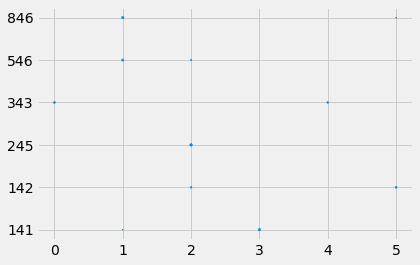

In [29]:
cluster_scatter_plot(tbl_frm)

In [30]:
 tbl_frm.head()

,cat,cluster,count
0,141,1,1
1,141,3,6
2,142,2,3
3,142,5,4
4,245,2,7


In [31]:
def compute_building_share(original_df, kmeans_df, tbl_frm):
    bld_share = {}
    for tp in original_df['cat'].unique():
        tot_num_buildings = len(original_df[original_df.cat == tp].groupby('NIS'))
        bld_share[tp] = {}
        for c in kmeans_df['cluster'].unique():
            nb = tbl_frm[(tbl_frm.cat == tp) & (tbl_frm.cluster == c)]['count']
            if not nb.empty:
                bld_share[tp][c] = int(nb) / tot_num_buildings
    return bld_share

In [32]:
bld_share = compute_building_share(dd, kmeans_df, tbl_frm)
tbl_frm['bld_pct'] = tbl_frm.apply(lambda row: bld_share[row['cat']][row['cluster']], axis = 1)

In [33]:
def norm_cluster_scatter_plot(tbl_frm):
    type_uniq, type_n = np.unique(tbl_frm['cat'], return_inverse = True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x = tbl_frm['cluster'], y = type_n, s = tbl_frm['bld_pct'].apply(lambda x: x * 100))
    ax.set(yticks = np.unique(type_n), yticklabels = type_uniq);

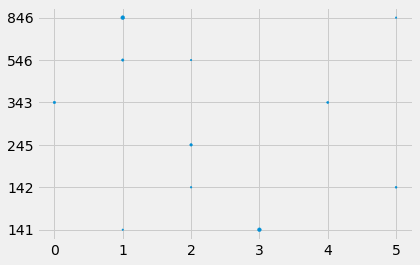

In [34]:
norm_cluster_scatter_plot(tbl_frm)

In [35]:
def multiline_hourly_plot(dataset, avg = None, ycol = 'KWh', ymin = None, ymax = None, opacity = None, title = None):
    fig, ax = plt.subplots()
    
    if ymin is not None:
        ax.set_ylim(bottom = ymin)
    
    if ymax is not None:
        ax.set_ylim(top = ymax)
        
    if opacity is None:
        opacity = 0.01

    for key, group in dataset:
        ax = group.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#000000', alpha = opacity)
    
    if avg is not None:
        ax = avg.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#FF0000', alpha = 1, linewidth = 2)
        
    if title is not None:
        ax.set_title(title)

    ax.legend().set_visible(False) # Disable the plot legend
    plt.show()

In [36]:
def clusters_visualisation(kmeans_df, id_vars, value_vars):
    melt_df = pd.melt(kmeans_df, id_vars = id_vars, value_vars = value_vars, var_name = 'hour', value_name = 'norm_KWh')
    clusters = kmeans_df['cluster'].unique()
    clusters.sort()
    for c in clusters:
        avg = melt_df[melt_df.cluster == c]
        data = avg.groupby(id_vars)
        multiline_hourly_plot(data, avg = avg, ymin = 0, ycol = 'norm_KWh', opacity = 0.1, title = 'Cluster ' + str(c))

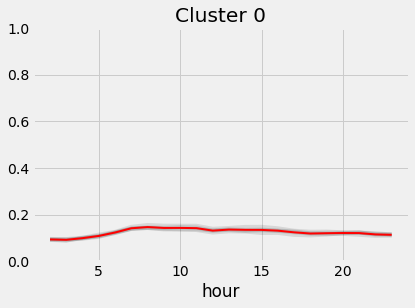

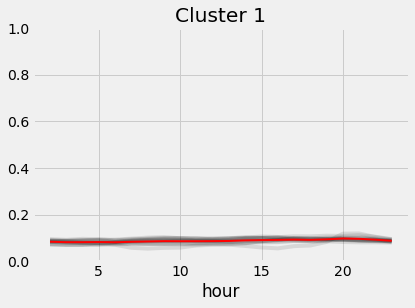

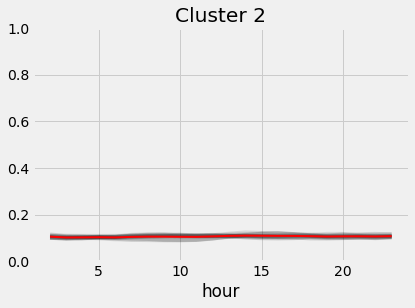

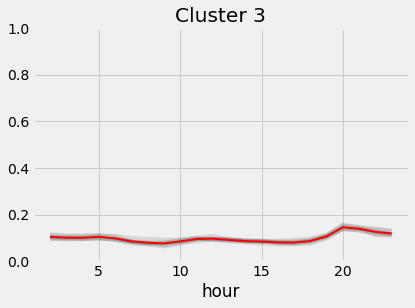

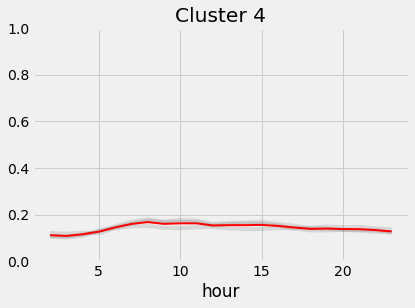

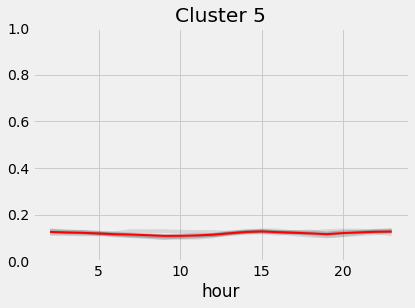

In [38]:
clusters_visualisation(kmeans_df, id_vars = ['cat', 'day', 'cluster'], value_vars = list(kmeans_df.columns[4:28]))